Dataset https://www.kaggle.com/datasets/mohamedabdelwahabali/drugreview/data

In [1]:
# Standard import
import os
from IPython.display import display
import re

# 3rd party import
# - Casual
import pandas as pd
import numpy as np
# - Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
# - NLP
import contractions
import spacy
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
# - Modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
import tensorflow as tf 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# Local import

In [2]:
train_df = pd.read_csv('../data/drug_review_train.csv')
val_df = pd.read_csv('../data/drug_review_validation.csv')
test_df = pd.read_csv('../data/drug_review_test.csv')

# EDA

In [3]:
display(train_df.head())
display(val_df.head())
display(test_df.head())

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2,20 Apr 13,69,147
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7,7 Aug 16,4,136
2,2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1,11 May 16,6,140
3,3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10,19 Mar 12,124,104
4,4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9,1 Aug 10,101,74


,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,191114,Campral,alcohol dependence,"""sober a year 8-25-11. god, aa and campral hav...",10.0,"September 3, 2011",33,41
1,1,142693,Levonorgestrel,birth control,"""i've been on birth control for a while now du...",4.0,"August 9, 2017",3,140
2,2,71561,Vraylar,bipolar disorde,"""hi, this is an updated experience. \r\r\n\r\r...",8.0,"August 16, 2016",12,131
3,3,25765,Ethinyl estradiol / norelgestromin,birth control,"""i have been on the ortho evra patch for just ...",8.0,"September 15, 2013",16,138
4,4,12843,Etanercept,psoriasis,"""i have been on enbrel for 7 years and i have ...",9.0,"August 5, 2010",9,65


,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,163740,Mirtazapine,depression,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012",22,68
1,1,206473,Mesalamine,"crohn's disease, maintenance","""my son has crohn's disease and has done very ...",8.0,"May 17, 2009",17,48
2,2,39293,Contrave,weight loss,"""contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,143
3,3,97768,Cyclafem 1 / 35,birth control,"""i have been on this birth control for one cyc...",9.0,"October 22, 2015",4,149
4,4,208087,Zyclara,keratosis,"""4 days in on first 2 weeks. using on arms an...",4.0,"July 3, 2014",13,60


In [4]:
display(train_df.info())
display(val_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110811 entries, 0 to 110810
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     110811 non-null  int64 
 1   patient_id     110811 non-null  int64 
 2   drugName       110811 non-null  object
 3   condition      110811 non-null  object
 4   review         110811 non-null  object
 5   rating         110811 non-null  int64 
 6   date           110811 non-null  object
 7   usefulCount    110811 non-null  int64 
 8   review_length  110811 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 7.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27703 entries, 0 to 27702
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     27703 non-null  int64  
 1   patient_id     27703 non-null  int64  
 2   drugName       27703 non-null  object 
 3   condition      27703 non-null  object 
 4   review         27703 non-null  object 
 5   rating         27703 non-null  float64
 6   date           27703 non-null  object 
 7   usefulCount    27703 non-null  int64  
 8   review_length  27703 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46108 entries, 0 to 46107
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     46108 non-null  int64  
 1   patient_id     46108 non-null  int64  
 2   drugName       46108 non-null  object 
 3   condition      46108 non-null  object 
 4   review         46108 non-null  object 
 5   rating         46108 non-null  float64
 6   date           46108 non-null  object 
 7   usefulCount    46108 non-null  int64  
 8   review_length  46108 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 3.2+ MB


None

In [5]:
print("Unique drugs in train set:", len(train_df['drugName'].unique())) # not important

Unique drugs in train set: 2865


## Dependent variable - 'rating' preprocessing - part 1/2

### Notice that there is dtype mismatch issue for 'rating'

In [6]:
def check_rating_consistency(train_df, val_df, test_df):
    """Check if ratings are truly compatible"""
    
    # Check for non-integer values in val/test
    val_non_int = val_df[~val_df['rating'].apply(float.is_integer)] 
    test_non_int = test_df[~test_df['rating'].apply(float.is_integer)]
    
    print(f"Non-integer ratings in val: {len(val_non_int)}")
    print(f"Non-integer ratings in test: {len(test_non_int)}")
    
    # Check value ranges
    print(f"\nTrain rating range: {train_df['rating'].min()} to {train_df['rating'].max()}")
    print(f"Val rating range: {val_df['rating'].min()} to {val_df['rating'].max()}")
    print(f"Test rating range: {test_df['rating'].min()} to {test_df['rating'].max()}")

check_rating_consistency(train_df, val_df, test_df)

Non-integer ratings in val: 0
Non-integer ratings in test: 0

Train rating range: 1 to 10
Val rating range: 1.0 to 10.0
Test rating range: 1.0 to 10.0


In [7]:
# All decimals are .0, convert to int
val_df['rating'] = val_df['rating'].astype(np.int64)
test_df['rating'] = test_df['rating'].astype(np.int64)

print("Val rating dtype:", val_df['rating'].dtype)
print("Test rating dtype:", test_df['rating'].dtype)

Val rating dtype: int64
Test rating dtype: int64


### Add a feature: 'sentiment'

In [8]:
def sentiments_label(rating):
    if rating >= 7:
        return 'positive'
    elif rating >= 4:
        return 'neutral'
    else:
        return 'negative'

# Apply sentiment labeling (corrected)
train_df['sentiment'] = train_df['rating'].apply(sentiments_label)
val_df['sentiment'] = val_df['rating'].apply(sentiments_label)
test_df['sentiment'] = test_df['rating'].apply(sentiments_label)

## Visualizations

### Sentiment distribution

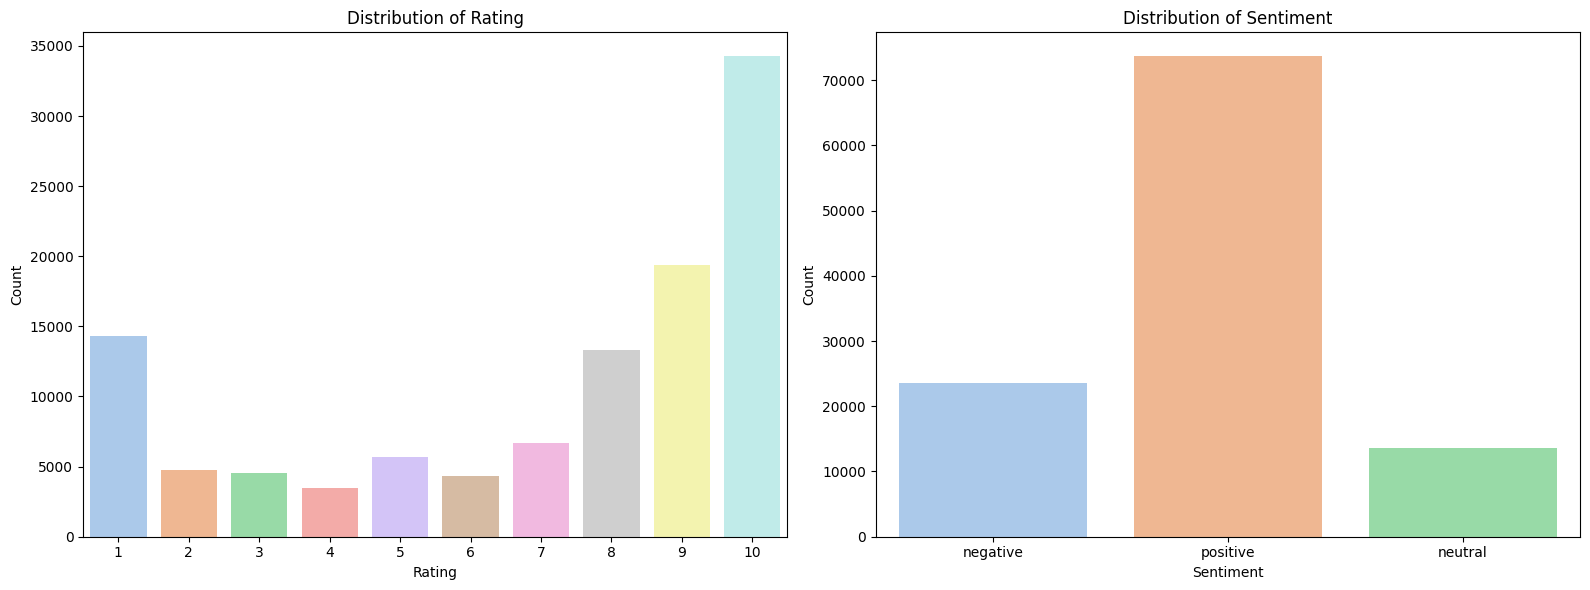

In [9]:
# Create 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Rating distribution
sns.countplot(x='rating', hue='rating', data=train_df, palette='pastel', legend=False, ax=ax1)
ax1.set_title('Distribution of Rating')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')

# Sentiment distribution
sns.countplot(x='sentiment', hue='sentiment', data=train_df, palette='pastel', legend=False, ax=ax2)
ax2.set_title('Distribution of Sentiment')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [10]:
print("=== TRAIN DATAFRAME SENTIMENT DISTRIBUTION ===")
train_counts = train_df['sentiment'].value_counts()
train_percentages = train_df['sentiment'].value_counts(normalize=True) * 100
print("Counts:")
print(train_counts)
print("\nPercentages:")
print(train_percentages)
print("-" * 50)

=== TRAIN DATAFRAME SENTIMENT DISTRIBUTION ===
Counts:
sentiment
positive    73638
negative    23602
neutral     13571
Name: count, dtype: int64

Percentages:
sentiment
positive    66.453691
negative    21.299329
neutral     12.246979
Name: proportion, dtype: float64
--------------------------------------------------


In [11]:
print("=== VALIDATION DATAFRAME SENTIMENT DISTRIBUTION ===")
val_counts = val_df['sentiment'].value_counts()
val_percentages = val_df['sentiment'].value_counts(normalize=True) * 100
print("Counts:")
print(val_counts)
print("\nPercentages:")
print(val_percentages)
print("-" * 50)

# Show sentiment distribution in test data
print("=== TEST DATAFRAME SENTIMENT DISTRIBUTION ===")
test_counts = test_df['sentiment'].value_counts()
test_percentages = test_df['sentiment'].value_counts(normalize=True) * 100
print("Counts:")
print(test_counts)
print("\nPercentages:")
print(test_percentages)
print("-" * 50)

=== VALIDATION DATAFRAME SENTIMENT DISTRIBUTION ===
Counts:
sentiment
positive    18344
negative     5834
neutral      3525
Name: count, dtype: int64

Percentages:
sentiment
positive    66.216655
negative    21.059091
neutral     12.724254
Name: proportion, dtype: float64
--------------------------------------------------
=== TEST DATAFRAME SENTIMENT DISTRIBUTION ===
Counts:
sentiment
positive    30409
negative     9993
neutral      5706
Name: count, dtype: int64

Percentages:
sentiment
positive    65.951679
negative    21.673029
neutral     12.375293
Name: proportion, dtype: float64
--------------------------------------------------


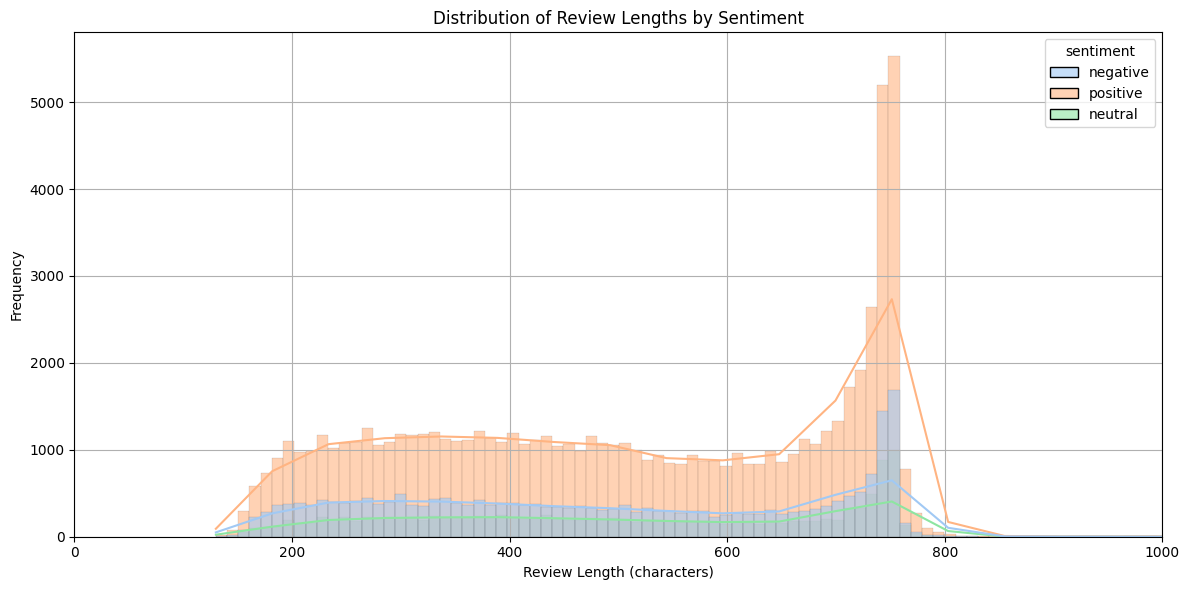

In [12]:
txt_len = train_df['review'].astype(str).apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x=txt_len, hue="sentiment", kde=True, bins=1000, palette="pastel", alpha=0.6) 
plt.title("Distribution of Review Lengths by Sentiment")
plt.xlabel("Review Length (characters)")
plt.ylabel("Frequency")
# plt.xscale('log')  # Logarithmic scale
plt.xlim(0, 1000)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\chun\AppData\Local\Temp\ipykernel_25320\3683608119.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='sentiment', y=txt_len, palette="pastel")


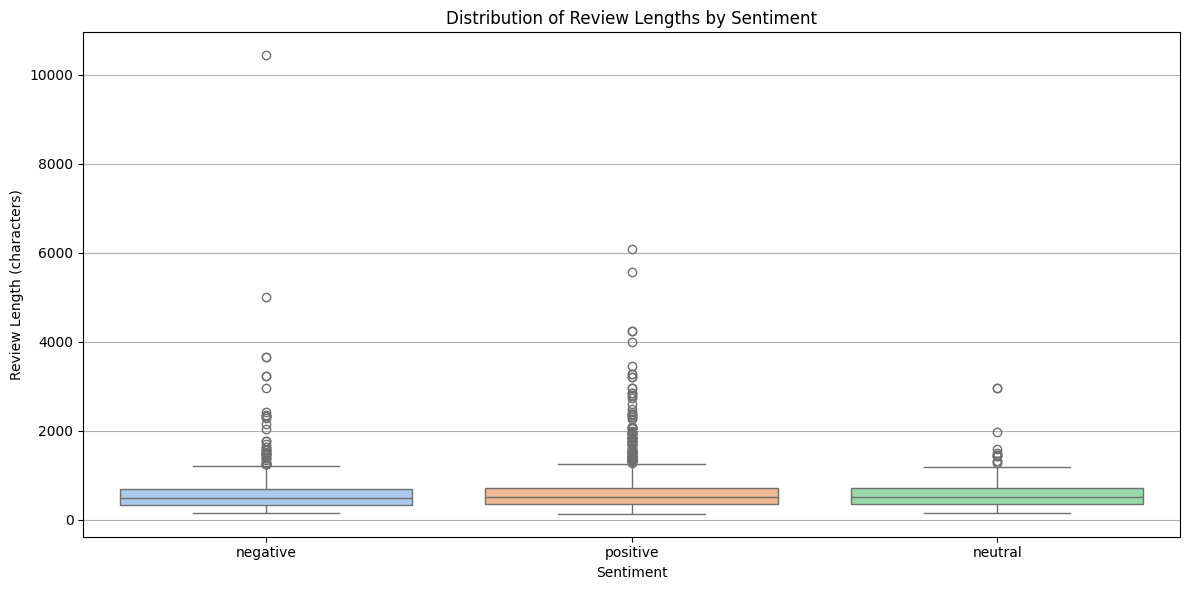

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='sentiment', y=txt_len, palette="pastel")
plt.title("Distribution of Review Lengths by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Review Length (characters)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## Issues discovered in EDA

1. Data type mismatch for rating --- Solved in EDA
2. Class imbalance --- Solved in Data Preprocessing

# Data Preprocessing

### Feature selection

In [14]:
# Select only the 'review' and 'rating' columns; Drop all the others
train_df = train_df[['review', 'sentiment']]
val_df = val_df[['review', 'sentiment']]
test_df = test_df[['review', 'sentiment']]

## Dependent variable - 'rating' preprocessing - part 2/2 

### Label encoding

In [15]:
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# train_df['sentiment_encoded'] = label_encoder.fit_transform(train_df['sentiment'])
# val_df['sentiment_encoded'] = label_encoder.transform(val_df['sentiment'])
# test_df['sentiment_encoded'] = label_encoder.transform(test_df['sentiment'])
# print("Label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

train_df['sentiment_encoded'] = train_df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
val_df['sentiment_encoded'] = val_df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
test_df['sentiment_encoded'] = test_df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

### Check if null values exist

In [16]:
display(train_df.isnull().sum())
display(val_df.isnull().sum())
display(test_df.isnull().sum())

review               0
sentiment            0
sentiment_encoded    0
dtype: int64

review               0
sentiment            0
sentiment_encoded    0
dtype: int64

review               0
sentiment            0
sentiment_encoded    0
dtype: int64

## Independent variable - 'review' text preprocessing

### Decontract

In [17]:
train_df['review'] = train_df['review'].apply(lambda x: contractions.fix(str(x)))
val_df['review'] = val_df['review'].apply(lambda x: contractions.fix(str(x)))
test_df['review'] = test_df['review'].apply(lambda x: contractions.fix(str(x)))

print("Input:", "I can't believe it's not butter!")
print("Output:", contractions.fix("I can't believe it's not butter!")) # Output: I cannot believe it is not butter!

Input: I can't believe it's not butter!
Output: I cannot believe it is not butter!


### Lowercase, HTML tags / URLs / special characters removal

In [18]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub(r'\W', ' ', text) # remove non-alphabet
    text = re.sub(r'\s+', ' ', text).strip() # remove extra spaces
    return text

In [19]:
train_df['review'] = train_df['review'].apply(normalize_text)
val_df['review'] = val_df['review'].apply(normalize_text)
test_df['review'] = test_df['review'].apply(normalize_text)

### Stopwords removal

In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = str(text).split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

train_df['review'] = train_df['review'].apply(remove_stopwords)
val_df['review'] = val_df['review'].apply(remove_stopwords)
test_df['review'] = train_df['review'].apply(remove_stopwords)

# Quick verification if nltk stopword removal works
print("Input:", "this is a great medication and it works very well")
print("Output:", remove_stopwords("this is a great medication and it works very well"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Input: this is a great medication and it works very well
Output: great medication works well


### Lemmatization 

In [21]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded")
    
except OSError:
    print("Downloading spaCy model...")
    os.system("python -m spacy download en_core_web_sm")
    
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded")

spaCy model loaded


In [22]:
def spacy_lemmatize(text):
    text = str(text)
    if not text.strip(): return "" # checks for empty/whitespace-only strings
    
    doc = nlp(text) # <- spacy automatically tokenizes here
    # doc contains tokens like: [I, like, cat]

    lemmas = [
        token.lemma_.lower() 
        for token in doc 
        # if not token.is_stop and not token.is_punct and not token.is_space
    ]
    
    return ' '.join(lemmas)

In [23]:
# Quick verification if spaCy lemmatization works
quick_tests = [
    "I'm feeling much better after taking this medication", 
    "The side effects were getting worse over time" 
]

for test in quick_tests:
    result = spacy_lemmatize(test)
    print(f"\nInput:  {test}")
    print(f"Output: {result}")
    # print(f"Reduction: {len(test.split())} → {len(result.split())} words")


Input:  I'm feeling much better after taking this medication
Output: i be feel much well after take this medication

Input:  The side effects were getting worse over time
Output: the side effect be get bad over time


In [24]:
# Apply spaCy lemmatization to df['review']
print("Applying spaCy lemmatization to training data...")
train_df['review'] = train_df['review'].apply(spacy_lemmatize)

print("Applying spaCy lemmatization to validation data...")
val_df['review'] = val_df['review'].apply(spacy_lemmatize)

print("Applying spaCy lemmatization to test data...")
test_df['review'] = test_df['review'].apply(spacy_lemmatize)

print("\nspaCy lemmatization completed!")

Applying spaCy lemmatization to training data...
Applying spaCy lemmatization to validation data...
Applying spaCy lemmatization to test data...

spaCy lemmatization completed!


### Tokenization

In [25]:
# spaCy already tokenized during lemmatization,
# It's just converted back to strings for storage, 
# Vectorizers will re-tokenize automatically

# Save & load processed variables

### Save variables

In [ ]:
train_df.to_pickle('train_df.pkl.gz', compression='gzip')
val_df.to_pickle('val_df.pkl.gz', compression='gzip')
test_df.to_pickle('test_df.pkl.gz', compression='gzip')

### Load variables

In [ ]:
train_df = pd.read_pickle('train_df.pkl.gz', compression='gzip')
val_df = pd.read_pickle('val_df.pkl.gz', compression='gzip')
test_df = pd.read_pickle('test_df.pkl.gz', compression='gzip')

### View variables

In [27]:
display(train_df.head())
display(val_df.head())
display(test_df.head())

,review,sentiment,sentiment_encoded
0,use restasis year see almost progress life red...,negative,0
1,experience somewhat mixed use implanon nearly ...,positive,2
2,second implanon would recommend first one okay...,negative,0
3,recommend take prescribe bottle usually say ta...,positive,2
4,ampyra 5 day happy new pill first 2 day good s...,positive,2


,review,sentiment,sentiment_encoded
0,sober year 8 25 11 god aa campral work craving...,positive,2
1,birth control due horrendous cramp excessively...,neutral,1
2,hi update experience vraylar 2 month side effe...,positive,2
3,ortho evra patch month first apply patch small...,positive,2
4,enbrel 7 year tell awesome able thing never th...,positive,2


,review,sentiment,sentiment_encoded
0,use restasis year see almost progress life red...,positive,2
1,experience somewhat mixed use implanon nearly ...,positive,2
2,second implanon would recommend first one okay...,positive,2
3,recommend take prescribe bottle usually say ta...,positive,2
4,ampyra 5 day happy new pill first 2 day good s...,neutral,1


## Class imbalance solution

In [28]:
# # Manual class weight calculation
# # Data: 73638 positive, 23602 negative, 13571 neutral

# total_samples = 73638 + 23602 + 13571  # = 110811
# n_classes = 3

# weight_negative = total_samples / (n_classes * 23602)  # ~1.56
# weight_neutral = total_samples / (n_classes * 13571)   # ~2.72
# weight_positive = total_samples / (n_classes * 73638)  # ~0.50

In [29]:
y_train = train_df['sentiment_encoded']
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict) # Use in model.fit(..., class_weight=class_weight_dict) / LinearSVC(class_weight='balanced')

sample_weights = np.array([class_weight_dict[label] for label in y_train])

Class weights: {0: np.float64(1.564994491992204), 1: np.float64(2.721759634514774), 2: np.float64(0.5016024335261685)}


## Vectorization

In [30]:

tfidf = TfidfVectorizer(max_features=8000)
X_train = tfidf.fit_transform(train_df['review'])
X_val = tfidf.transform(val_df['review'])
X_test = tfidf.transform(test_df['review'])

y_train = train_df['sentiment_encoded']
y_val = val_df['sentiment_encoded']
y_test = test_df['sentiment_encoded']

In [31]:
print(f"Samples: {X_train.shape[0]}")  # 110811 entries of review
print(f"Features: {X_train.shape[1]}") # 5000 features (TF-IDF dimensions)

Samples: 110811
Features: 8000


# Modeling

## Traditional ML

In [32]:
### Models that supports class_weight='balanced'

models_A = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', # class_weight=class_weight_dict; Handle class imbalance
        random_state=42, 
        max_iter=1000
    ),
    
    'SVM': LinearSVC(
        class_weight='balanced',  
        random_state=42
    ),
    
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',  
        random_state=42, 
        n_estimators=100
    ),
}

### Models that don't support class_weight='balanced'

models_B = {
    'Naive Bayes': MultinomialNB(),
    
    'XGBoost': XGBClassifier(
        # Use scale_pos_weight for binary, but for multi-class:
        # XGBoost automatically handles imbalance in multi-class
        random_state=42
    )
}

In [33]:
best_model = None
best_val_score = 0

for name, model in models_A.items():
    model.fit(X_train, y_train) #
    y_pred = model.predict(X_val)
    val_score = f1_score(y_val, y_pred, average='macro')
    
    print(f"{name}: {val_score:.4f}")
    
    if val_score > best_val_score:
        best_model = model
        best_val_score = val_score

for name, model in models_B.items():
    model.fit(X_train, y_train, sample_weight=sample_weights) #
    y_pred = model.predict(X_val)
    val_score = f1_score(y_val, y_pred, average='macro')
    
    print(f"{name}: {val_score:.4f}")
    
    if val_score > best_val_score:
        best_model = model
        best_val_score = val_score

Logistic Regression: 0.6065
SVM: 0.6148
Random Forest: 0.7612
Naive Bayes: 0.5554
XGBoost: 0.6156


In [34]:
print(f"\nBest model: {type(best_model).__name__}")


Best model: RandomForestClassifier


In [35]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)

rf.fit(X_train, y_train, sample_weight=sample_weights)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [36]:
y_pred = rf.predict(X_val)

In [37]:
y_pred

array([2, 1, 2, ..., 2, 0, 2], shape=(27703,))

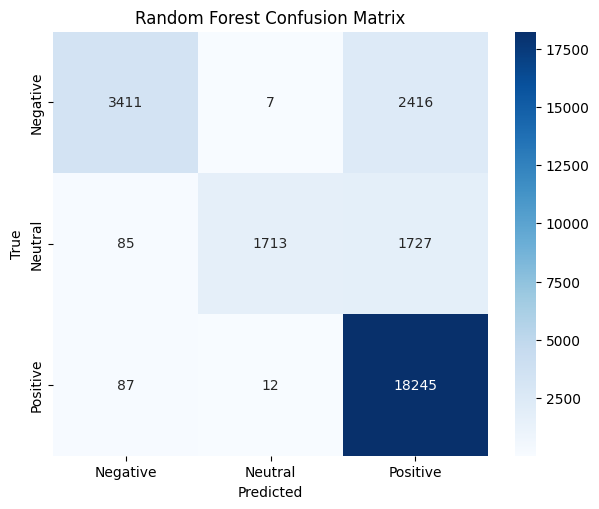

Confusion matrix
              precision    recall  f1-score   support

    negative       0.95      0.58      0.72      5834
     neutral       0.99      0.49      0.65      3525
    positive       0.81      0.99      0.90     18344

    accuracy                           0.84     27703
   macro avg       0.92      0.69      0.76     27703
weighted avg       0.87      0.84      0.83     27703

Accuracy: 84.36%
Precision (Macro): 91.87%
Recall (Macro): 68.84%
F1 Score (Macro): 75.73%


In [38]:
rf_cm = pd.DataFrame(data=confusion_matrix(y_val, y_pred),
                      columns=['Negative', 'Neutral', 'Positive'],
                      index=['Negative', 'Neutral', 'Positive'])

plt.figure(figsize = (6, 5))
plt.title('Random Forest Confusion Matrix')
sns.heatmap(rf_cm, annot=True, fmt='d', cmap="Blues")
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Confusion matrix')
print(classification_report(y_val, y_pred, target_names=['negative', 'neutral', 'positive']))

# Multi-class metrics
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_val, y_pred)))
print("Precision (Macro): {:.2f}%".format(100 * precision_score(y_val, y_pred, average='macro')))
print("Recall (Macro): {:.2f}%".format(100 * recall_score(y_val, y_pred, average='macro')))
print("F1 Score (Macro): {:.2f}%".format(100 * f1_score(y_val, y_pred, average='macro')))

## Deep learning - RNN

In [39]:
# Step 1: Initialize Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")

# Step 2: Fit on training data
print("Fitting tokenizer on training data...")
tokenizer.fit_on_texts(train_df['review'])

# Step 3: Convert texts to sequences
print("Converting tokens to sequences...")
X_train_seq = tokenizer.texts_to_sequences(train_df['review'])
X_val_seq = tokenizer.texts_to_sequences(val_df['review'])
X_test_seq = tokenizer.texts_to_sequences(test_df['review'])

# Step 4: Analyze sequence lengths to choose maxlen
train_lengths = [len(seq) for seq in X_train_seq]
print(f"Sequence length stats:")
print(f"  Min: {np.min(train_lengths)}")
print(f"  Max: {np.max(train_lengths)}")
print(f"  Mean: {np.mean(train_lengths):.1f}")
print(f"  95th percentile (words): {np.percentile(train_lengths, 95):.1f}")

Fitting tokenizer on training data...
Converting tokens to sequences...
Sequence length stats:
  Min: 9
  Max: 939
  Mean: 48.0
  95th percentile (words): 76.0


In [40]:
# Step 5: Pad sequences
maxlen = 100 # int(np.percentile(train_lengths, 95)) 
print(f"Padding sequences to length: {maxlen}")

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

print(f"Final shapes:")
print(f"  X_train_pad: {X_train_pad.shape}")
print(f"  X_val_pad: {X_val_pad.shape}")
print(f"  X_test_pad: {X_test_pad.shape}")

Padding sequences to length: 100
Final shapes:
  X_train_pad: (110811, 100)
  X_val_pad: (27703, 100)
  X_test_pad: (46108, 100)


In [54]:
y_train.dtype

dtype('int64')

In [41]:
max_words = 5000
rnn = Sequential([
    Input(shape=(maxlen,)),
    Embedding(input_dim=max_words, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

rnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 747,267 (2.85 MB)

 Trainable params: 747,267 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

rnn.fit(
    X_train_pad, 
    y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=64,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1,
)

Epoch 1/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 91s 53ms/step - accuracy: 0.7842 - loss: 0.5549 - val_accuracy: 0.7054 - val_loss: 0.6908
Epoch 2/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 96s 55ms/step - accuracy: 0.7985 - loss: 0.5108 - val_accuracy: 0.7300 - val_loss: 0.6805
Epoch 3/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 93s 54ms/step - accuracy: 0.8173 - loss: 0.4642 - val_accuracy: 0.7334 - val_loss: 0.6764
Epoch 4/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 92s 53ms/step - accuracy: 0.8349 - loss: 0.4148 - val_accuracy: 0.7282 - val_loss: 0.7590
Epoch 5/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 94s 54ms/step - accuracy: 0.8520 - loss: 0.3689 - val_accuracy: 0.7608 - val_loss: 0.6970
Epoch 6/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 99s 57ms/step - accuracy: 0.8649 - loss: 0.3303 - val_accuracy: 0.7588 - val_loss: 0.7616


In [49]:
y_pred_proba = rnn.predict(X_val_pad)

866/866 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step


In [50]:
y_pred_proba

array([[1.7198499e-05, 2.5369200e-05, 9.9995744e-01],
       [1.2477330e-01, 3.7304986e-01, 5.0217682e-01],
       [6.8191320e-02, 7.5049108e-01, 1.8131757e-01],
       ...,
       [1.8886197e-02, 4.2584208e-01, 5.5527174e-01],
       [3.3759290e-01, 6.0275531e-01, 5.9651822e-02],
       [9.2345528e-02, 8.1878567e-01, 8.8868774e-02]],
      shape=(27703, 3), dtype=float32)

In [51]:
print("\nFirst 5 samples' probabilities:")
for i in range(5):
    print(f"Sample {i}: {y_pred_proba[i]} → Sum: {y_pred_proba[i].sum():.3f}")


First 5 samples' probabilities:
Sample 0: [1.7198499e-05 2.5369200e-05 9.9995744e-01] → Sum: 1.000
Sample 1: [0.1247733  0.37304986 0.5021768 ] → Sum: 1.000
Sample 2: [0.06819132 0.7504911  0.18131757] → Sum: 1.000
Sample 3: [0.00634093 0.01071893 0.9829401 ] → Sum: 1.000
Sample 4: [0.00472744 0.1455772  0.84969527] → Sum: 1.000


In [52]:
# Convert probabilities to class labels (0, 1, 2)
y_pred = np.argmax(y_pred_proba, axis=1)

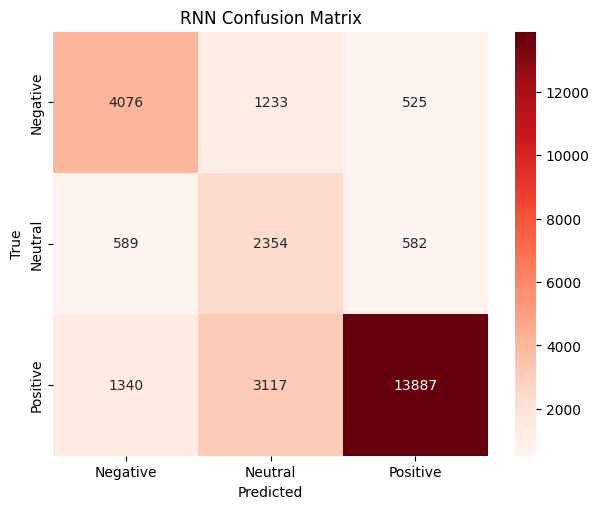

Confusion matrix
              precision    recall  f1-score   support

    negative       0.68      0.70      0.69      5834
     neutral       0.35      0.67      0.46      3525
    positive       0.93      0.76      0.83     18344

    accuracy                           0.73     27703
   macro avg       0.65      0.71      0.66     27703
weighted avg       0.80      0.73      0.76     27703

Accuracy: 73.34%
Precision (Macro): 65.20%
Recall (Macro): 70.78%
F1 Score (Macro): 66.06%


In [53]:
# Create confusion matrix DataFrame for 3 classes
rnn_cm = pd.DataFrame(data=confusion_matrix(y_val, y_pred),
                      columns=['Negative', 'Neutral', 'Positive'],
                      index=['Negative', 'Neutral', 'Positive'])

plt.figure(figsize = (6, 5))
plt.title('RNN Confusion Matrix')
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap="Reds")
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Confusion matrix')
print(classification_report(y_val, y_pred, target_names=['negative', 'neutral', 'positive']))

# Multi-class metrics
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_val, y_pred)))
print("Precision (Macro): {:.2f}%".format(100 * precision_score(y_val, y_pred, average='macro')))
print("Recall (Macro): {:.2f}%".format(100 * recall_score(y_val, y_pred, average='macro')))
print("F1 Score (Macro): {:.2f}%".format(100 * f1_score(y_val, y_pred, average='macro')))